<a href="https://colab.research.google.com/github/Mufid99/Kindle_reviews_sentiment_analysis/blob/main/Kindle_reviews_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download meetnagadia/amazon-kindle-book-review-for-sentiment-analysis 
! unzip amazon-kindle-book-review-for-sentiment-analysis.zip

 78% 5.00M/6.38M [00:00<00:00, 20.4MB/s]
100% 6.38M/6.38M [00:00<00:00, 21.2MB/s]
Archive:  amazon-kindle-book-review-for-sentiment-analysis.zip
  inflating: all_kindle_review .csv  
  inflating: preprocessed_kindle_review .csv  


In [3]:
!pip install nlpaug
!pip install -qq transformers[sentencepiece]
!pip install -qq datasets

     |████████████████████████████████| 410 kB 13.4 MB/s 
     |████████████████████████████████| 11.3 MB 27.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


     |████████████████████████████████| 3.4 MB 13.3 MB/s 
     |████████████████████████████████| 895 kB 38.3 MB/s 
     |████████████████████████████████| 61 kB 471 kB/s 
     |████████████████████████████████| 3.3 MB 37.6 MB/s 
     |████████████████████████████████| 596 kB 42.5 MB/s 
     |████████████████████████████████| 1.2 MB 31.6 MB/s 
     |████████████████████████████████| 306 kB 12.4 MB/s 
     |████████████████████████████████| 243 kB 46.1 MB/s 
     |████████████████████████████████| 1.1 MB 47.7 MB/s 
     |████████████████████████████████| 132 kB 39.2 MB/s 
     |████████████████████████████████| 192 kB 48.7 MB/s 
     |████████████████████████████████| 271 kB 37.8 MB/s 
     |████████████████████████████████| 160 kB 51.6 MB/s 


In [4]:
import transformers
import datasets
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nlpaug
import nlpaug.augmenter.word as nlpaw
import tqdm
import nltk


from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler
from datasets import Dataset, load_metric
from datasets.arrow_dataset import concatenate_datasets
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
df = pd.read_csv('preprocessed_kindle_review .csv')
df.head()

AttributeError: ignored

   Unnamed: 0  ...                          summary
0           0  ...                50 + years ago...
1           1  ...          Boring! Boring! Boring!
2           2  ...  Wiggleliscious/new toy ready/!!
3           3  ...                  Very good read.
4           4  ...                     Great Story!

[5 rows x 4 columns]

In [7]:
df.shape

(12000, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12000 non-null  int64 
 1   rating      12000 non-null  int64 
 2   reviewText  12000 non-null  object
 3   summary     12000 non-null  object
dtypes: int64(2), object(2)
memory usage: 375.1+ KB


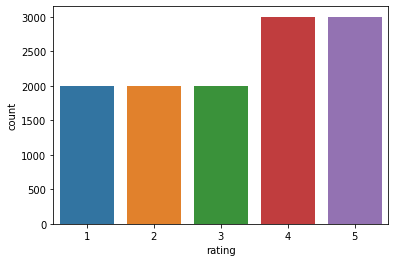

In [9]:
ax = sns.countplot(x = df['rating'])
sns.countplot(x = df['rating'])

We will be transforming the ratings into positive, negative and neutral sentiments to be predicted. 

Before that, we will be transforming the Pandas dataframe into a Hugging Face Dataset since we will be using this with out Hugging Face model.

In [10]:
def to_sentiment(example):
  rating = example['rating']
  if rating <= 2:
    example['rating'] = 0
  elif rating == 3:
    example['rating'] = 1
  else: 
    example['rating'] = 2
  
  return example

data = Dataset.from_pandas(df)
data = data.map(to_sentiment)

  0%|          | 0/12000 [00:00<?, ?ex/s]

Now after we have transformed the ratings, let's split the data into a train, val, test split.

In [11]:
data = data.train_test_split(train_size=0.9, seed=RANDOM_SEED)
val_test_data = data['test'].train_test_split(train_size=0.5, seed=RANDOM_SEED)
data['validation'] = val_test_data.pop('train')
data['test'] = val_test_data.pop('test')
data = data.remove_columns(['Unnamed: 0','summary'])
data

DatasetDict({
    train: Dataset({
        features: ['rating', 'reviewText'],
        num_rows: 10800
    })
    test: Dataset({
        features: ['rating', 'reviewText'],
        num_rows: 600
    })
    validation: Dataset({
        features: ['rating', 'reviewText'],
        num_rows: 600
    })
})

Text(0.5, 0, 'review sentiment')

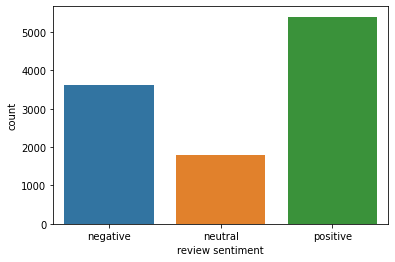

In [12]:
ax = sns.countplot(x = data['train']['rating'])
sns.countplot(x = data['train']['rating'])
labels = ['negative', 'neutral', 'positive']
ax.set_xticklabels(labels)
plt.xlabel('review sentiment')

We can see that there is an imbalance in the training data, so it is a good idea to rebalance the data by oversampling 

In [13]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
aug = nlpaw.SynonymAug(aug_src='wordnet',aug_max=2)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [14]:
def augment_text(examples, aug, num_times, rating):
    final_reviews = []
    for text in examples['reviewText']:
      new_sequences = aug.augment(text, n=num_times)
      final_reviews += [text] + new_sequences
    
    ratings = np.ones(len(final_reviews), dtype=np.int8) * rating
    return {'reviewText': final_reviews, 'rating': ratings}

In [15]:
# to_augment = data['train'].filter(lambda x: x['rating'] == 1) # get the rows with neutral sentiment

# augmented_data = to_augment.map(augment_text, batched=True, 
#                           fn_kwargs={'aug': aug,
#                                      'num_times': 2, 'rating': 1})
# augmented_data

In [16]:
# data['train'] = concatenate_datasets([data['train'].filter(lambda x: x['rating'] != 1), augmented_data])
# data['train']

Text(0.5, 0, 'review sentiment')

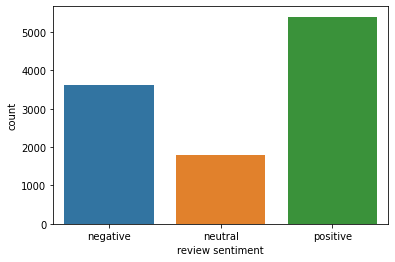

In [17]:
ax = sns.countplot(x = data['train']['rating'])
sns.countplot(x = data['train']['rating'])
labels = ['negative', 'neutral', 'positive']
ax.set_xticklabels(labels)
plt.xlabel('review sentiment')

Now that we have inflated the number of neutral data points and we have a sufficient amount from each class, we can start training a model to predict the sentiment.

In [18]:
# checkpoint = "bert-base-cased"
checkpoint = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
  return tokenizer(examples['reviewText'], truncation=True)

tokenized_dataset = data.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
tokenized_dataset = tokenized_dataset.remove_columns(['reviewText'])
tokenized_dataset = tokenized_dataset.rename_column('rating', 'labels')
tokenized_dataset.set_format('torch')
tokenized_dataset['train'].column_names

['attention_mask', 'input_ids', 'labels']

In [20]:
batch_size = 8
train_dataloader = DataLoader(tokenized_dataset['train'], shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader = DataLoader(tokenized_dataset['validation'], shuffle=True, batch_size=batch_size, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_dataset['validation'], shuffle=True, batch_size=batch_size, collate_fn=data_collator)

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifi

In [22]:
optimizer = AdamW(model.parameters(), lr=2e-5)
EPOCHS = 10
num_steps = EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_steps,
)
print(num_steps)

13500


In [23]:
model.to(device)
device

device(type='cuda', index=0)

In [24]:
def train_epoch(model, 
  data_loader,  
  optimizer, 
  device, 
  scheduler):
  
  acc_metric = load_metric("accuracy")
  model = model.train()
  losses = []
  count = 0
  for batch in data_loader:
    count+=1
    batch = {k: v.to(device) for k,v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    losses.append(loss.item())
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    acc_metric.add_batch(predictions=predictions, references=batch["labels"])
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
  
  return acc_metric.compute(), np.mean(losses)

In [25]:
def eval_model(model, data_loader, device):
  model = model.eval()
  acc_metric = load_metric("accuracy")
  losses = []
  with torch.no_grad():
    for batch in data_loader:
      batch = {k: v.to(device) for k,v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      losses.append(loss.item())
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      acc_metric.add_batch(predictions=predictions, references=batch["labels"])

  return acc_metric.compute(), np.mean(losses)



In [26]:
model_save_name = 'example.pth'
path = f"/content/drive/MyDrive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
print(len(train_dataloader))
for i in range(EPOCHS):
  print(f'Epoch {i + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device, lr_scheduler)
  print(f'Train loss {train_loss} {train_acc}')
  val_acc, val_loss = eval_model(model, val_dataloader, device)
  print(f'Val   loss {val_loss} {val_acc}')




Epoch 1/10
----------


Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

1350
Train loss 0.6240478188296159 {'accuracy': 0.7519444444444444}
Val   loss 0.638893578449885 {'accuracy': 0.745}
Epoch 2/10
----------
1350
